<a href="https://colab.research.google.com/github/HyeonhoonLee/KIOM_KDC/blob/master/KDC_RandomForest_GradientBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KIOM 한의임상정보은행 data 분석하기

일단 데이터를 추출해서 상관분석을 전부 돌려보자.

# 라이브러리 로드

In [1]:
# 분석에 사용할 pandas, 수치계산에 사용할 numpy, 시각화에 사용할 seaborn 을 불러옵니다.
# 또, 구 버전의 주피터 노트북에서는 %matplotlib inline 설정을 되어야 노트북 안에서 그래프를 시각화 합니다.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#한글 폰트 설정

In [2]:
# Google Colab 사용 시 아래 주석을 풀고 폰트설정을 합니다.
# 로컬 아나콘다 사용 시에는 그대로 주석처리 해놓으시면 됩니다.
# 나눔고딕 설치
# 이 코드를 사용시 아래에 있는 폰트를 로드할 경우 colab에서는 오류가 발생하니
# 아래에 있는 폰트 설정은 꼭 주석처리를 해주세요. 
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

fm._rebuild()

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumGothic') 
# 마이너스 폰트 깨지는 문제에 대한 대처
plt.rc("axes", unicode_minus=False)

In [3]:
# 레티나 설정을 해주면 글씨가 좀 더 선명하게 보입니다.
# 폰트의 주변이 흐릿하게 보이는 것을 방지합니다.
%config InlineBackend.figure_format = 'retina'

#데이터 불러오기

- 데이터 로드 주소: https://www.data.go.kr/data/3072201/fileData.do
- 임상정보은행 사이트에서 상세이용방법 확인가능 (https://kdc.kiom.re.kr/html/?pmode=subpage&MMC_pid=200&spSeq=22)

In [4]:
# 다운로드 받은 파일을 판다스의 read_csv 를 통해 읽어옵니다.
# 파일을 읽어온 후 shape 로 행과 열의 수를 출력합니다.

##새로만든 csv에는 인코딩을 따로 지정하지 않아도된다.
df = pd.read_csv("/content/drive/My Drive/DataCollection/KIOM_KDC/data/KDC_feature.csv")
df.shape

(500, 82)

In [5]:
# sample, head, tail을 통해 데이터를 미리보기 합니다.
df.head()

,대상자식별코드,성별,만나이,직업분류,학력,결혼유무,성격_대범_섬세,성격_행동빠름_행동느림,성격_적극_소극,성격_직접_간접,성격_포기빠름_포기느림,성격_외향_내성,성격_동적_정적,성격_쉽게_어렵게,성격_남성적_여성적,성격_참을성부족_잘찾음,성격_큰편_적은편,성격_잘드러냄_안드러냄,성격_잘표현_표현안하는편,성격_가끔흥분_이성적,성격_덜렁_꼼꼼,식사량,식사속도,소화여부,소화입맛,땀정도,땀기분,대변습관,대변굳기,배변시긴박감,배변후잔변감,소변야간뇨,한열민감도,한열손부위,한열발부위,한열배부위,음수정도,음수온다,한열점수,한열그룹,...,고지혈증_진단,일반건강,수면시간(시간),수면시간(분),피로정도,피로_기상시,피로_오전,피로_오후,피로_밤,피로_하루종일,한의사체질진단,키,몸무게,BMI,이마둘레,목둘레,겨드랑이둘레,가슴둘레,늑골둘레,허리둘레,장골둘레,곡골둘레,수축기혈합,이완기혈압,혈당,총콜레스테롤,중성지방,고밀도콜레스테롤,저밀도콜레스테롤,수면시간(시간)_부족,늑골둘레_low,늑골둘레_middle,늑골둘레_high,혈당_nan,총콜레스테롤_nan,중성지방_nan,고밀도콜레스테롤_nan,저밀도콜레스테롤_nan,혈당_log,중성지방_log
0,KDCT00001,2,0.036746,2,5,2,2,2,1,2,1,1,1.0,2.0,2,3,2,2,2,1,1,2.000000,2.0,1,3,3,1.0,1,2,2.490637,2.314607,1.0,1,2,2,2,2.0,2,12.0,2.0,...,1,3.0,5,0,2,0,0,0,1,0,2,-0.372588,-0.551481,-0.421862,-1.411128,-0.532671,0.266128,0.606435,89.0,-0.140773,0.167260,0.414628,0.017181,0.342702,0.220807,0.964152,-0.652711,0.941597,0.672927,1.542199,-0.376235,-1.040833,1.344987,0.219656,0.963293,-0.652738,0.937537,0.671852,4.653960,4.290459
1,KDCT00002,2,2.013834,14,3,2,1,1,1,1,1,1,1.0,2.0,1,3,1,1,1,1,3,2.000000,2.0,1,3,1,2.0,1,2,2.490637,2.314607,1.0,2,2,2,2,2.0,3,13.0,3.0,...,1,3.0,5,0,4,0,0,1,0,0,3,-0.748940,0.221659,0.869741,1.713833,0.077630,0.774588,1.211515,93.0,0.909300,0.814851,0.871402,0.267996,-1.005102,0.453146,0.376917,-0.343301,-0.196630,0.210896,1.542199,-0.376235,-1.040833,1.344987,0.451957,0.376095,-0.343379,-0.199521,0.209862,4.709530,4.584967
2,KDCT00003,1,0.119384,3,3,2,3,1,1,1,1,1,1.0,1.0,1,2,1,1,1,1,3,3.000000,2.0,3,2,3,1.0,1,2,2.490637,2.314607,1.0,3,2,3,2,2.0,2,12.0,2.0,...,1,3.0,7,0,2,0,0,1,0,0,2,-0.121687,-0.164911,-0.114338,0.672179,0.687931,0.647473,-0.119661,83.0,-0.350787,-1.127923,-1.869239,0.079885,-0.106566,-0.747269,0.876066,-0.454689,0.047276,0.804936,-0.648425,-0.376235,0.960769,-0.743502,-0.748265,0.875213,-0.454748,0.044134,0.803849,4.382027,4.488636
3,KDCT00004,2,0.152821,14,4,2,1,1,1,1,1,1,1.0,2.0,1,1,1,2,1,1,2,2.078385,1.0,3,2,2,3.0,2,2,2.490637,2.314607,1.0,2,2,2,2,1.0,2,15.0,3.0,...,1,4.0,7,0,4,0,0,1,0,0,2,0.505566,1.478013,1.392533,1.713833,0.687931,1.283048,1.574564,90.0,0.804292,0.555815,0.871402,-0.421745,0.432555,0.065915,0.934790,0.139377,-0.359233,0.936945,-0.648425,-0.376235,-1.040833,1.344987,0.064789,0.933933,0.139222,-0.361958,0.935846,4.615121,4.919981
4,KDCT00005,1,0.093090,8,2,2,3,2,3,2,2,3,2.0,2.0,2,3,3,2,2,2,1,2.000000,1.0,1,3,1,2.0,1,2,2.490637,2.314607,0.0,1,3,3,2,1.0,2,11.0,2.0,...,1,2.0,5,0,4,0,0,1,0,0,1,0.505566,0.898158,0.715979,2.234660,1.603383,2.045738,1.332531,99.0,1.539343,1.073888,1.023660,0.581515,-0.376127,-0.243870,-0.004785,-0.788851,-1.253554,0.342905,1.542199,-0.376235,-1.040833,1.344987,-0.244946,-0.005584,-0.788856,-1.255361,0.341859,4.532599,4.127134


# 학습과 예측에 사용할 데이터셋 만들기

In [6]:
df.columns

Index(['대상자식별코드', '성별', '만나이', '직업분류', '학력', '결혼유무', '성격_대범_섬세',
       '성격_행동빠름_행동느림', '성격_적극_소극', '성격_직접_간접', '성격_포기빠름_포기느림', '성격_외향_내성',
       '성격_동적_정적', '성격_쉽게_어렵게', '성격_남성적_여성적', '성격_참을성부족_잘찾음', '성격_큰편_적은편',
       '성격_잘드러냄_안드러냄', '성격_잘표현_표현안하는편', '성격_가끔흥분_이성적', '성격_덜렁_꼼꼼', '식사량',
       '식사속도', '소화여부', '소화입맛', '땀정도', '땀기분', '대변습관', '대변굳기', '배변시긴박감',
       '배변후잔변감', '소변야간뇨', '한열민감도', '한열손부위', '한열발부위', '한열배부위', '음수정도', '음수온다',
       '한열점수', '한열그룹', '고혈압_진단', '당뇨_진단', '고지혈증_진단', '일반건강', '수면시간(시간)',
       '수면시간(분)', '피로정도', '피로_기상시', '피로_오전', '피로_오후', '피로_밤', '피로_하루종일',
       '한의사체질진단', '키', '몸무게', 'BMI', '이마둘레', '목둘레', '겨드랑이둘레', '가슴둘레', '늑골둘레',
       '허리둘레', '장골둘레', '곡골둘레', '수축기혈합', '이완기혈압', '혈당', '총콜레스테롤', '중성지방',
       '고밀도콜레스테롤', '저밀도콜레스테롤', '수면시간(시간)_부족', '늑골둘레_low', '늑골둘레_middle',
       '늑골둘레_high', '혈당_nan', '총콜레스테롤_nan', '중성지방_nan', '고밀도콜레스테롤_nan',
       '저밀도콜레스테롤_nan', '혈당_log', '중성지방_log'],
      dtype='object')

In [7]:
# 이 중 feature engineeringd에서 score가 괜찮았던 것만 고른다.
# 즉, train에 사용할 column명만 가져온다.
X = df[['성별', '만나이', '직업분류', '학력', '결혼유무', '성격_대범_섬세',
       '성격_행동빠름_행동느림', '성격_적극_소극', '성격_직접_간접', '성격_포기빠름_포기느림', '성격_외향_내성',
       '성격_동적_정적', '성격_쉽게_어렵게', '성격_남성적_여성적', '성격_참을성부족_잘찾음', '성격_큰편_적은편',
       '성격_잘드러냄_안드러냄', '성격_잘표현_표현안하는편', '성격_가끔흥분_이성적', '성격_덜렁_꼼꼼', '식사량',
       '식사속도', '소화여부', '소화입맛', '땀정도', '땀기분', '대변습관', '대변굳기', '배변시긴박감',
       '배변후잔변감', '소변야간뇨', '한열민감도', '한열손부위', '한열발부위', '한열배부위', '음수정도', '음수온다',
       '한열점수', '한열그룹', '고혈압_진단', '당뇨_진단', '고지혈증_진단', '일반건강', '피로정도', '피로_기상시', 
       '피로_오전', '피로_오후', '피로_밤', '피로_하루종일','키', '몸무게', 'BMI', '이마둘레', '목둘레', '겨드랑이둘레', 
       '가슴둘레','허리둘레', '장골둘레', '곡골둘레', '수축기혈합', '이완기혈압', '수면시간(시간)_부족', '늑골둘레_low', 
       '늑골둘레_middle', '늑골둘레_high', '총콜레스테롤_nan', '중성지방_nan', '고밀도콜레스테롤_nan',
       '저밀도콜레스테롤_nan', '혈당_log', '중성지방_log']]
X.shape

(500, 71)

In [8]:
y = df['한의사체질진단']
y.shape

(500,)

In [9]:
# 사이킷런에서 제공하는 model_selection 의 train_test_split 으로 만듭니다.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [10]:
# train 세트의 문제와 정답의 데이터 수를 확인해 주세요.

X_train.shape, y_train.shape

((400, 71), (400,))

In [11]:
# test 세트의 문제와 정답의 데이터 수를 확인해 주세요.

X_test.shape, y_test.shape

((100, 71), (100,))

# 머신러닝 알고리즘 사용하기
* [결정 트리 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EA%B2%B0%EC%A0%95_%ED%8A%B8%EB%A6%AC)
* [결정 트리 학습법 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EA%B2%B0%EC%A0%95_%ED%8A%B8%EB%A6%AC_%ED%95%99%EC%8A%B5%EB%B2%95)
* [랜덤 포레스트 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8)
* [배깅 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EB%B0%B0%EA%B9%85)
<img src="https://upload.wikimedia.org/wikipedia/commons/8/83/0_jW2hAGmYEFH0RP9W.png">

이미지 출처 : https://upload.wikimedia.org/wikipedia/commons/8/83/0_jW2hAGmYEFH0RP9W.png

###  Single tree

In [35]:
# Single tree의 장점은 시각화가 용이하다는 것이다. 우리가 직접 그림을 보고 대입해서 분류를 할 수 있다.
# 특히, Feature engineering과정에서 필요하므로, single tree를 먼저하고 random forest로 넘어가는 게 좋다.
# from sklearn.tree import DecisionTreeClassifier

# model = DecisionTreeClassifier(random_state=42)
# model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

### Bagging
* Bagging은 Bootstrap aggregating의 준말. 초기 앙상블 방법(한 개 이상의 결정 트리.
* 위의 그림과 같이 Super Population에서 sampling하는 과정을 bootstrapping이라고 한다.
* 반복적으로 데이터를 교체하는 과정에 따라, 훈련 데이터를 재샘플링하고, 다시 다수의 의사결정트리를 생성해서 학습하므로 overfitting을 줄일 수 있다. 

In [39]:
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model
# #n_estimators는 만드는 tree의 갯수. 현재 버전에서는 기본값이 100개.

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### Boosting 
* https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/


In [47]:
# data에 weight를 줘서 sequential하게 Tree를 만든다.

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=42)
model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# 학습과 예측하기

In [48]:
# 학습을 시킵니다.
model.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [49]:
# Random Forest 모델의 중요도를 살펴봅니다.
model.feature_importances_

array([2.79661497e-03, 4.13015833e-02, 3.76485925e-03, 1.48826584e-02,
       3.20042990e-03, 2.05986006e-02, 2.23030554e-02, 3.05589777e-02,
       1.63192987e-03, 4.94119120e-03, 2.92629905e-03, 1.37267780e-02,
       4.33956038e-03, 5.34476720e-04, 3.67753973e-03, 2.13073587e-03,
       1.29303328e-03, 6.14398313e-03, 7.50932924e-03, 5.89269441e-04,
       4.39861390e-03, 1.22283381e-02, 3.79204209e-03, 2.29683821e-02,
       1.86847019e-02, 3.81305581e-03, 2.58432143e-03, 4.92208807e-03,
       4.97006306e-03, 4.91911004e-03, 3.35783846e-03, 4.19936781e-03,
       1.41247680e-02, 3.19113304e-03, 3.61407197e-03, 1.57259205e-03,
       7.83232324e-03, 3.96068506e-02, 4.58004367e-03, 1.39336628e-04,
       0.00000000e+00, 2.02217572e-03, 3.09219164e-03, 1.93600919e-03,
       7.56681454e-06, 7.06809211e-03, 8.57046807e-04, 1.53782828e-07,
       5.25291818e-03, 4.57456127e-02, 3.22872517e-02, 9.77596138e-02,
       1.72542730e-02, 3.98417127e-02, 2.01098714e-02, 1.07400967e-01,
      

In [50]:
feature_names = X_train.columns.tolist()

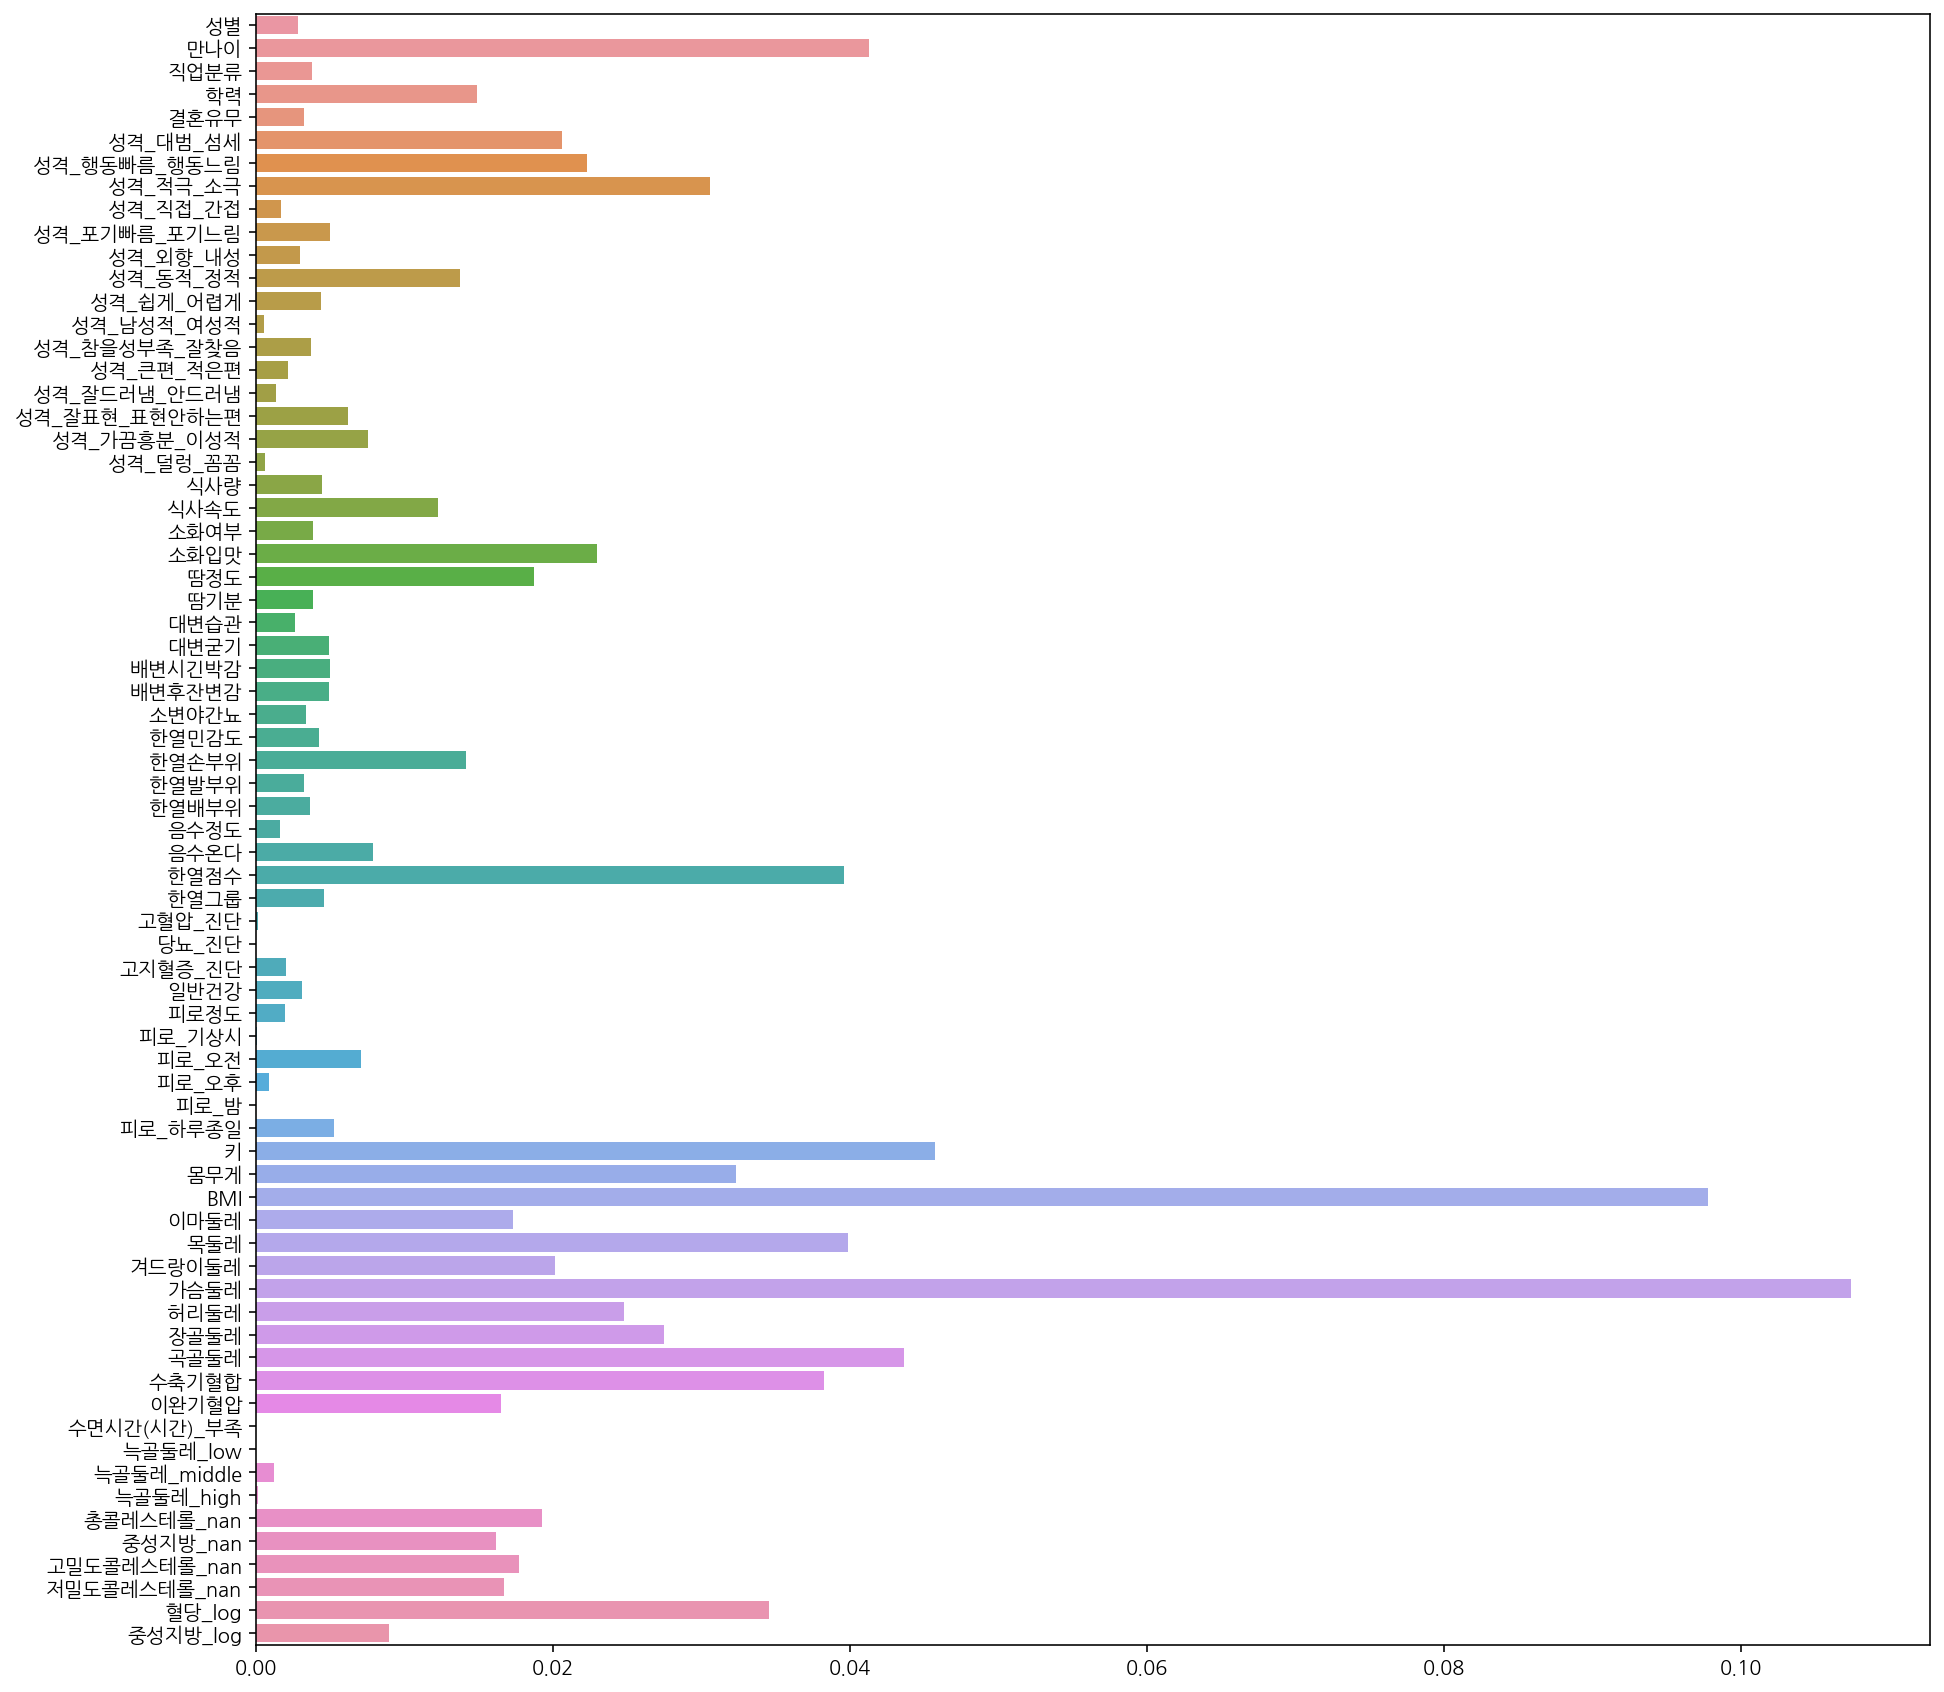

In [51]:
# 중요도를 시각화합니다.
plt.figure(figsize=(15,15))
sns.barplot(x=model.feature_importances_, y=feature_names)

In [52]:
# #Random Forest는 시각화해줄 수 없다.

# from sklearn.tree import plot_tree

# plt.figure(figsize=(15, 15))
# tree = plot_tree(model, feature_names=feature_names, fontsize=10, filled=True)

In [53]:
# #graphviz 를 통해 시각화 합니다.
# #graphviz 는 별도의 설치가 필요합니다. 
# #graphviz 와 파이썬에서 graphviz 를 사용할 수 있게 해주는 도구 2가지를 설치해 주셔야 합니다.
# import graphviz
# from sklearn.tree import export_graphviz

# dot_tree = export_graphviz(model,
#                            feature_names = feature_names,
#                            filled=True)
# graphviz.Source(dot_tree)

In [54]:
 # 예측을 하고 결과를 y_predict에 담습니다.
y_predict = model.predict(X_test)
y_predict

array([2, 1, 3, 1, 1, 3, 3, 1, 1, 3, 2, 1, 1, 1, 1, 1, 3, 1, 3, 2, 3, 1,
       1, 2, 1, 1, 1, 1, 2, 2, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1,
       1, 3, 3, 2, 2, 1, 3, 3, 3, 1, 1, 3, 1, 3, 2, 1, 3, 3, 3, 1, 1, 1,
       2, 1, 1, 2, 3, 3, 3, 2, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 2, 3,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 3, 3])

# 정확도(Accuracy) 측정하기

In [55]:
# 다르게 예측한 갯수를 구해서 diff_count 에 할당해 줍니다.
# DT : 51
# RF : 49
# GB : 53
(y_predict != y_test).sum()

53

In [56]:
# 예측의 정확도를 구해봅니다.
y_predict_list = y_predict.tolist()
y_test_list = y_test.tolist()
acc = 0
for i in range(len(y_predict_list)):
  if y_predict_list[i] == y_test_list[i]:
    acc += 1
print("정확도 : ", acc/len(y_predict_list))

정확도 :  0.47


In [57]:
# 위에서 처럼 직접 구할 수도 있지만 미리 구현된 알고리즘을 가져와 사용합니다.

from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_predict) * 100

47.0

In [58]:
# model 의 score 로 점수를 계산합니다.
model.score(X_test, y_test) * 100

47.0

In [59]:
#1 single tree: acc 49%  
#2 Random Forest: acc 51%
#3 Gradient boosting: acc 47%